##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [3]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Import TensorFlow and other libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import glob
import tqdm

## Load the dataset

You can download this dataset and similar datasets from [here](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets). As mentioned in the [paper](https://arxiv.org/abs/1611.07004) we apply random jittering and mirroring to the training dataset.

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [2]:
def reshape_img(fl):
    fl_ = np.zeros((384,384,fl.shape[0]))
    for c in range(fl.shape[0]):
        fl_[:,:,c] = fl[c,:,:]
    return fl_

def reshape_img_arr(img):
    img_ = np.zeros((384, 384, img.shape[1]))
    for c in range(img.shape[1]):
        img_[:,:,:,c] = img[:,c,:,:]
    return img_

def clean_3d(img):
    img_ = np.zeros_like(img)
    for c in range(img.shape[-1]):
        img_[:,:,c] = img[:,:,c] - img[:,:,c].min()
        img_[:,:,c] = img_[:,:,c]/img_[:,:,c].max()
    return img_

In [3]:
def load_img_folder(folder, pattern="*20X*.npy"):
    br_arr = []; fl_arr = []
    for img_file in tqdm.tqdm(glob.glob(folder+pattern)):
        data = np.load(img_file,allow_pickle=True)
        for p in range(data.shape[0]):
            try:
                br = reshape_img(data[p,:,0,:,:])
                br = clean_3d(br)
                fl = clean_3d(reshape_img(data[p,1,1:,:,:]))
                br_arr.append(br)
                fl_arr.append(fl)
            except IndexError:
                print("IndexError in: " + img_file)
                break
    return np.array(br_arr), np.array(fl_arr)

In [4]:
br_arr, fl_arr = load_img_folder("../../shared/patches/norm_40X/", pattern="*40X*.npy")

100%|██████████| 15/15 [02:31<00:00, 10.13s/it]


In [5]:
fl_arr.shape

(4250, 384, 384, 3)

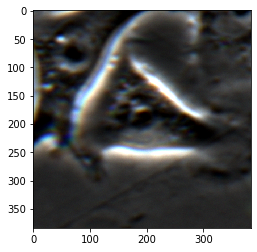

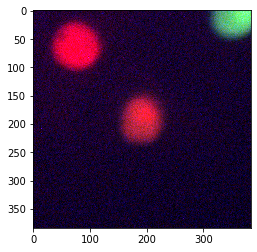

In [8]:
# Show just the first image patch in the sequence
br = br_arr[15,:,:,:]
fl = fl_arr[15,:,:,:]
plt.figure()
plt.imshow(br)
plt.figure()
plt.imshow(fl)

In [9]:
BUFFER_SIZE = 1000
BATCH_SIZE = 5
IMG_WIDTH = 384
IMG_HEIGHT = 384

In [10]:
def load_image_train():
    for i in range(br_arr.shape[0]):
        br_image = tf.cast(br_arr[i,:,:,:],tf.float32)
        fl_image  = tf.cast(fl_arr[i,:,:,:],tf.float32)
        br_image, fl_image = random_jitter(br_image, fl_image)
        br_image, fl_image = normalize(br_image, fl_image)
        yield br_image, fl_image

In [11]:
def resize(br_image, fl_image, height, width):
    br_image = tf.image.resize(br_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    fl_image = tf.image.resize(fl_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return br_image, fl_image

In [12]:
def random_crop(br_image, fl_image):
    stacked_image = tf.stack([br_image, fl_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [13]:
# normalizing the images to [-1, 1]
def normalize(br_image, fl_image):
    br_image = (br_image*2) - 1
    fl_image = (fl_image*2) - 1

    return br_image, fl_image

In [14]:
@tf.function()
def random_jitter(br_image, fl_image):
    # resizing to 314 x 314 x 3
    br_image, fl_image = resize(br_image, fl_image, 420, 420)

    # randomly cropping to 256 x 256 x 3
    br_image, fl_image = random_crop(br_image, fl_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        br_image = tf.image.flip_left_right(br_image)
        fl_image = tf.image.flip_left_right(fl_image)

    if tf.random.uniform(()) > 0.5:
        # random up-down mirror
        br_image = tf.image.flip_up_down(br_image)
        fl_image = tf.image.flip_up_down(fl_image)

    return br_image, fl_image

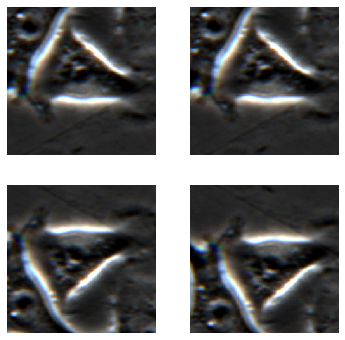

In [15]:
# As you can see in the images below
# that they are going through random jittering
# Random jittering as described in the paper is to
# 1. Resize an image to bigger height and width
# 2. Randomnly crop to the original size
# 3. Randomnly flip the image horizontally

plt.figure(figsize=(6, 6))
for i in range(4):
    rj_br, rj_fl = random_jitter(br, fl)
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_br)
    plt.axis('off')
plt.show()

## Input Pipeline

In [16]:
train_dataset = tf.data.Dataset.from_generator(load_image_train, (tf.float32, tf.float32))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [17]:
# train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
# train_dataset = train_dataset.map(load_image_train,
#                                   num_parallel_calls=tf.data.experimental.AUTOTUNE)
# train_dataset = train_dataset.shuffle(BUFFER_SIZE)
# train_dataset = train_dataset.batch(BATCH_SIZE)

In [18]:
# test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
# test_dataset = test_dataset.map(load_image_test)
# test_dataset = test_dataset.batch(BATCH_SIZE)

## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).



In [19]:
OUTPUT_CHANNELS = 3

In [20]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [21]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(br, 0))
print (down_result.shape)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(1, 192, 192, 3)


In [22]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [23]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 384, 384, 3)


In [40]:
def Generator():
    var_size = 4
    down_stack = [
    downsample(96, var_size, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(192, var_size), # (bs, 64, 64, 128)
    downsample(384, var_size), # (bs, 32, 32, 256)
    downsample(768, var_size), # (bs, 16, 16, 512)
    downsample(768, var_size), # (bs, 8, 8, 512)
    downsample(768, var_size), # (bs, 4, 4, 512)
    downsample(768, var_size), # (bs, 2, 2, 512)
#     downsample(768, var_size), # (bs, 1, 1, 512)
    ]
    up_stack = [
    upsample(768, var_size, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(768, var_size, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(768, var_size, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(768, var_size), # (bs, 16, 16, 1024)
    upsample(384, var_size), # (bs, 32, 32, 512)
    upsample(192, var_size), # (bs, 64, 64, 256)
    upsample(96, var_size), # (bs, 128, 128, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None,None,3])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [41]:
def Generator_old():
    down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
#     downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

    concat = tf.keras.layers.Concatenate()

    inputs = tf.keras.layers.Input(shape=[None,None,3])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


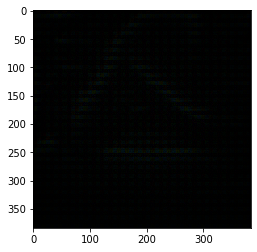

In [42]:
generator = Generator()

gen_output = generator(br[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...],cmap='gray')

## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * We concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [43]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[None, None, 3], name='br_image')
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



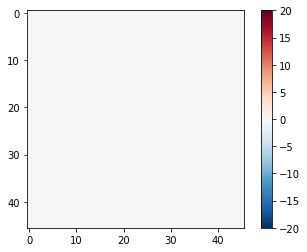

In [44]:
discriminator = Discriminator()
disc_out = discriminator([br[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

## Define the loss functions and the optimizer

* **Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss

* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

In [45]:
LAMBDA = 100

In [46]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [47]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [48]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss

In [49]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints (Object-based saving)

In [50]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Training

* We start by iterating over the dataset
* The generator gets the input image and we get a generated output.
* The discriminator receives the br_image and the generated image as the first input. The second input is the br_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* This entire procedure is shown in the images below.

![Discriminator Update Image](images/dis.png)


---


![Generator Update Image](images/gen.png)

## Generate Images

* After training, its time to generate some images!
* We pass images from the test dataset to the generator.
* The generator will then translate the input image into the output we expect.
* Last step is to plot the predictions and **voila!**

In [52]:
EPOCHS = 50

In [53]:
def generate_images(model, test_input, tar, epoch):
    # the training=True is intentional here since
    # we want the batch statistics while running the model
    # on the test dataset. If we use training=False, we will get
    # the accumulated statistics learned from the training dataset
    # (which we don't want)
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.savefig("epoch{}.png".format(epoch))
    plt.show()

In [54]:
@tf.function
def train_step(br_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(br_image, training=True)

        disc_real_output = discriminator([br_image, target], training=True)
        disc_generated_output = discriminator([br_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [55]:
def fit(train_ds, epochs):
    for epoch in tqdm.tqdm(range(epochs)):

        # Train
        for br_image, target in train_ds:
            train_step(br_image, target)

        clear_output(wait=True)

        # saving (checkpoint) the model every 20 epochs
        if (epoch) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            for example_input, example_target in train_ds.take(1):
                generate_images(generator, example_input, example_target, epoch)
                plt.savefig('epoch{}.png'.format(epoch+1))


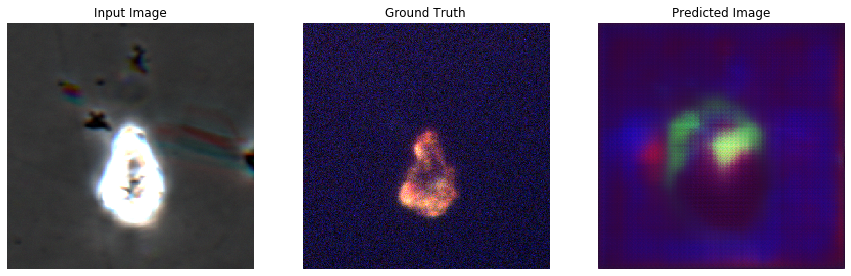

  2%|▏         | 1/50 [10:21<8:27:40, 621.64s/it]

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [56]:
fit(train_dataset, EPOCHS)